In [101]:
#All packages needed to run TwINFER simulation and inference are listed here. 
#If any of them are not installed, please install them using pip or conda env.
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numba
import tqdm
import scipy
import seaborn
import os
import sys
import joblib
from itertools import product

# Code to simulate a synthetic GRN and infer the network using TwINFER


## Details about the simulation

### Set this for both running the simulation and before inferring using TwINFER


In [103]:
#Path to TwINFER code repository
import os, sys
path_to_code_repo = os.path.abspath(getattr(sys.modules['__main__'], '__file__', os.getcwd()))


#Common path to data files
path_to_data = f"{path_to_code_repo}/simulation_example_input_data"
base_config = {
    'n_cells': 6000, #Number of cells before division (number of twin pairs)
    'simulation_time_before_division': 1000, #The time used to run the initial cells before division. User must set this time to ensure the population reaches steady state [hours]
    'twin_simulation_time_after_division': 48, #The time twin cells are simulated after division and measurements are stored in the output[hours]
    'twin_measurement_resolution': 1, #The time between each measurement of twin cells [hours]. For example, if twin_sampling_duration is 12 and twin_measurement_resolution is 1, the final dataframe will contain hourly measurements for 12 hours (0 is birth).
    "path_to_connectivity_matrix": f"{path_to_data}/connectivity_matrix_A_to_B.txt", #path to the connectivity matrix specifying the GRN to simulate
    "param_csv": f"{path_to_data}/median_parameter.csv", #Path to the parameters for all genes and interaction terms
    "rows_to_use": [[0,0]], #Rows in the parameter's csv file for each gene. Example - [0,0] will mean use row 0 parameters for both gene 1 and 2. The length should be equal to number of genes in the system.
    "output_folder": f"{path_to_code_repo}/example_simulation_output/", #Path to folder to store simulation 
    "log_file": f"{path_to_code_repo}/example_simulation_output/example_log.jsonl", #Path to the log file
    "type": ":inear_cascade",  # Name of the network used -- will be in the filename
    "number_of_parallel_parameters": 1, #Number of parameters to be run in parallel
    "number_of_cores_per_parameter": 4, #Number of cores to be used per parameter (number_of_parallel_parameters * number_of_cores_per_parameter = number of cores in your computer)
}

## Functions and packages used in this notebook - run this everytime notebook is restarted


### For the simulation


In [104]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import set_num_threads, get_num_threads

sys.path.append(str(path_to_code_repo))
set_num_threads(base_config['number_of_cores_per_parameter'])
print("Threads Numba will use:", get_num_threads())

import importlib
from TwINFER_function_scripts import gillespie_script
importlib.reload(gillespie_script)
from TwINFER_function_scripts.gillespie_script import process_param_set

Threads Numba will use: 4


### For inferring with TwINFER


In [96]:
# Calculation functions
import importlib
from TwINFER_function_scripts import correlation_analysis_functions
from TwINFER_function_scripts import correlation_analysis_helpers

importlib.reload(correlation_analysis_functions)
importlib.reload(correlation_analysis_helpers)

from TwINFER_function_scripts.correlation_analysis_functions import (
    
    calculate_pairwise_gene_gene_correlation_matrix,
    check_system_in_steady_state,
    check_gene_gene_correlation_threshold,
    calculate_twin_random_pair_correlations,
    differentiate_single_state_reg_and_multiple_states,
    identify_reg_if_multiple_states,
    get_cross_correlations,
    identify_actual_directed_edges
)

# Helper functions
from TwINFER_function_scripts.correlation_analysis_helpers import (
    extract_param_index,
    read_input_matrix,
    get_param_data, 
    plot_matrix_as_heatmap,
    print_summary,
    plot_network
)



In [122]:
def infer_with_twinfer(path_to_simulation_file= None, base_config=None, t1 = None, t2 = None, 
                        check_for_steady_state=True, 
                        threshold_gene_gene_corr=0.04, use_scramble = True, 
                        p_val_threshold_scrambled_gene_correlation = 0.01,
                        show_scrambled_distribution_gene_correlation = True,
                        z_score_threshold_two_states = 10,
                        p_value_threshold_cross_correlation = 0.01,
                        plot_correlation_matrices_as_heatmap=True,
                        have_any_output=True,
                        seed = 101010,
                        infer_direction_for_which_edges = "single-state"):
    """
    Infer gene regulatory interactions from simulated or experimental twin-cell data
    using the TwINFER pipeline.

    This function processes a single simulation (or equivalent experimental dataset)
    to:
      1. Check system steady state at an early timepoint.
      2. Compute gene–gene correlations at early and late timepoints.
      3. Classify candidate regulations as single-state or multiple-state.
      4. Infer directionality of single-state interactions from across-time twin pairs.
      5. Optionally visualize intermediate matrices and the inferred network.

    The approach uses twin cell pairs (descended from the same mother cell) and 
    compares their gene expression correlations at early and late post-division 
    times, as well as across-time twin measurements, to determine regulation type 
    and directionality.

    Parameters
    ----------
    path_to_simulation_file : str
        Path to the CSV file containing simulation or experimental output.
        The file should have one row per cell per timepoint, with at least:
        - 'clone_id': integer clone identifier.
        - 'cell_id': unique cell identifier.
        - 'time_step': time (in hours) post-division.
        - gene expression columns for each gene.

    base_config : dict
        Dictionary specifying simulation metadata and parameter sources:
            - "n_cells" : int
                Expected number of twin clones.
            - "twin_simulation_time_after_division" : int or float
                Duration after division covered in the simulation (hours).
            - "twin_measurement_resolution" : int or float
                Sampling resolution (hours).
            - "path_to_connectivity_matrix" : str
                File path to the interaction (connectivity) matrix.
            - "param_csv" : str
                File path to the parameter CSV file.
            - "rows_to_use" : list[list[int]]
                Parameter row indices corresponding to this simulation.

    t1 : int or float
        Early timepoint (hours) used for initial gene–gene correlation analysis.

    t2 : int or float
        Late timepoint (hours) used for twin vs random correlation comparison and 
        across-time directionality inference.

    threshold_gene_gene_corr : float, default=0.04
        Absolute correlation threshold above which gene–gene pairs are considered
        potential regulations.

    check_for_steady_state : bool, default=True
        If True, verifies that the system is in steady state at t1 using a mean and 
        slope threshold; raises ValueError if not steady.

    plot_correlation_matrices_as_heatmap : bool, default=True
        If True, generates heatmaps for:
            - Gene–gene correlations at t1
            - Twin and random correlations at t2
            - Directionality matrix

    have_any_output : bool, default=True
        If True, prints a summary of inferred regulations and shows network plots.

    Returns
    -------
    dict
        Dictionary containing:
            - "direction_matrix" : pd.DataFrame
                Normalized directional correlation matrix (t1 → t2) for single-state regulations.
            - "direction_raw_matrix" : pd.DataFrame
                Raw directional correlation differences without thresholding.
            - "pairwise_gene_gene_correlation_matrix" : pd.DataFrame
                Gene–gene Spearman correlation matrix at t1.
            - "twin_pair_correlation_matrix_t2" : pd.DataFrame
                Twin-cell correlation matrix at t2.
            - "random_pair_correlation_matrix_t2" : pd.DataFrame
                Random-cell correlation matrix at t2.
            - "twin_pair_correlation_matrix_t1" : pd.DataFrame
                Twin-cell correlation matrix at t1.
            - "random_pair_correlation_matrix_t1" : pd.DataFrame
                Random-cell correlation matrix at t1.

    Raises
    ------
    AssertionError
        If the number of clones or sampled timepoints in the simulation file does 
        not match `base_config`.
    ValueError
        If required timepoints t1 or t2 are missing from the data.
        If steady state is required and not reached.

    Notes
    -----
    - Clones are split into three disjoint sets for t1-only, t2-only, and across-time
      measurements in a 1:1:2 ratio.
    - Gene-gene and random-pair correlations uses all cell measurements at both time t1 and t2.
    - Across-time twin pairs are sampled by selecting one cell per clone at t1 and 
      one different cell at t2 from the same clone.
    - Single-state vs multiple-state regulation classification is based on the 
      difference between twin and random correlations at t2.
    - Directionality inference uses correlation differences between across-time 
      twin pairs at t1 and t2.
    """

    # Load simulation data
    try:
        simulation = pd.read_csv(path_to_simulation_file)
    except Exception as e:
        raise RuntimeError(f"Error reading the simulation file: {e}")

    # Load connectivity matrix and parameter set
    path_to_connectivity_matrix = base_config["path_to_connectivity_matrix"]
    path_to_parameter_csv = base_config["param_csv"]
    param_df = pd.read_csv(path_to_parameter_csv, index_col=0)

    # --- Basic sanity checks ---
    # Assert number of clones in simulation file matches config
    n_clones_simulation = simulation['clone_id'].nunique()
    n_clones_base_config = base_config["n_cells"]
    assert n_clones_simulation == n_clones_base_config, \
        "Number of twin pairs in the simulation file does not match n_cells in base_config."

    # Assert time points match expected resolution
    time_points_simulations = simulation['time_step'].unique()
    time_points_base_config = np.arange(
        0, 
        base_config['twin_simulation_time_after_division'] + base_config['twin_measurement_resolution'], 
        base_config['twin_measurement_resolution']
    )

    assert set(time_points_simulations) == set(time_points_base_config), \
        "The sampling time points in the simulation file do not match those specified in base_config."

    # Assert parameter row identity matches
    param_index_from_file_name = extract_param_index(path_to_simulation_file)
    param_index_from_base_config = "_".join(map(str, base_config["rows_to_use"][0]))
    assert param_index_from_file_name == param_index_from_base_config, \
        "Simulation parameters must match the details (parameter rows) in base_config."

    # Load gene parameters and connectivity structure
    n_genes, interaction_matrix = read_input_matrix(path_to_connectivity_matrix)
    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
    gene_params = get_param_data(param_df, param_index_from_file_name, n_genes)
    print(gene_params)

    valid_options = ["single-state", "all-edges"]
    if infer_direction_for_which_edges not in valid_options:
        raise ValueError(f"infer_direction_for_which_edges must be one of {valid_options}, got '{infer_direction_for_which_edges}'")
        
    # --- Check for steady state at t1 (optional) ---
    if check_for_steady_state:
        is_system_in_steady_state = check_system_in_steady_state(simulation, gene_params, interaction_matrix, gene_list,
                                  relative_diff_threshold=0.01, relative_slope_threshold=0.01)
        if not is_system_in_steady_state:
            raise ValueError(
                "The system is not in steady state. "
                "You can override this by setting check_for_steady_state=False."
            )

    # Ensure the time points t1 and t2 exist in the simulation data
    unique_timepoints = simulation['time_step'].unique()

    if t1 not in unique_timepoints:
        raise ValueError(f"Time point t1={t1} not found in simulation['time_step'].")
    if t2 not in unique_timepoints:
        raise ValueError(f"Time point t2={t2} not found in simulation['time_step'].")

    # Subset the simulation at the desired timepoints

    # Shuffle all clone IDs
    np.random.seed(seed)
    clone_ids_shuffled = np.random.permutation(n_clones_simulation)

    # Split into 1:1:2 ratio
    n1 = n2 = n_clones_simulation // 4
    t1_clones = clone_ids_shuffled[:n1]
    t2_clones = clone_ids_shuffled[n1:n1 + n2]
    across_t_clones = clone_ids_shuffled[n1 + n2:]

    # Subset directly
    t1_twins = simulation[(simulation['clone_id'].isin(t1_clones)) & (simulation['time_step'] == t1)]
    t2_twins = simulation[simulation['clone_id'].isin(t2_clones) & (simulation['time_step'] == t2)]

    # Across_t: pick exactly one random twin per clone_id
    # One cell per clone at t1
    across_t_twin1 = (
        simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t1) & (simulation['replicate'] == 1)]
    )
    
    across_t_twin2 = (
        simulation[(simulation['clone_id'].isin(across_t_clones)) & (simulation['time_step'] == t2) & (simulation['replicate'] == 2)]
    )

    # Reset index for cleanliness
    t1_twins = t1_twins.reset_index(drop=True)
    t2_twins = t2_twins.reset_index(drop=True)
    across_t_twin1 = across_t_twin1.reset_index(drop=True)
    across_t_twin2 = across_t_twin2.reset_index(drop=True)

    all_t1_t2_measurements = pd.concat(
    [t1_twins, t2_twins, across_t_twin1, across_t_twin2],
    ignore_index=True
    )

    # --- Step 1: Pairwise gene-gene correlations at t1 ---
    pairwise_gene_gene_correlation_matrix = calculate_pairwise_gene_gene_correlation_matrix(
        all_t1_t2_measurements, gene_list
    )
    no_regulation, potential_regulation, corr_threshold_used = check_gene_gene_correlation_threshold(
        all_t1_t2_measurements, pairwise_gene_gene_correlation_matrix, gene_list,  threshold = threshold_gene_gene_corr, use_scramble = True, p_val_threshold = p_val_threshold_scrambled_gene_correlation, verbose = show_scrambled_distribution_gene_correlation
    )
                
    # print(no_regulation)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap(corr_matrix=pairwise_gene_gene_correlation_matrix, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Gene-gene correlations across both timepoints", add_gene_labels=True, add_time=False, gray_out_no_reg=False
        )

    # --- Step 2: Twin/random correlations at t2 ---
    twin_pair_correlation_matrix_t1, random_pair_correlation_matrix_t2 = calculate_twin_random_pair_correlations(
        all_t1_t2_measurements, t1_twins, gene_list
    )
    # print(twin_pair_correlation_matrix_t2)
    if plot_correlation_matrices_as_heatmap:
        plot_matrix_as_heatmap( corr_matrix=twin_pair_correlation_matrix_t1, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Twin pair correlations at time {t1}h", add_gene_labels=True, add_time=True, time=[t1], gray_out_no_reg=True
        )
        
        plot_matrix_as_heatmap( corr_matrix=random_pair_correlation_matrix_t2, gene_list=gene_list, no_regulation=no_regulation, potential_regulation=potential_regulation,
            title=f"Random pair correlations across both time points", add_gene_labels=True, add_time=False, time=[t1], gray_out_no_reg=True
        )

    # --- Step 3: Classify regulation type: single-state vs multiple-states ---
    multiple_states_gene_pairs, single_state_regulation = differentiate_single_state_reg_and_multiple_states(
        all_t1_t2_measurements, potential_regulation, twin_pair_correlation_matrix_t1, random_pair_correlation_matrix_t2, gene_list, z_score_threshold=z_score_threshold_two_states
    )
    twin_pair_correlation_matrix_t2, random_pair_correlation_matrix_t1 = calculate_twin_random_pair_correlations(
                all_t1_t2_measurements, t2_twins, gene_list
            )
    if len(multiple_states_gene_pairs) > 0:

        multiple_states_no_reg, multiple_states_and_reg = identify_reg_if_multiple_states(
            twin_pair_correlation_matrix_t1,twin_pair_correlation_matrix_t2,random_pair_correlation_matrix_t1,
            random_pair_correlation_matrix_t2,multiple_states_gene_pairs,gene_list
            )
    else:
        multiple_states_no_reg, multiple_states_and_reg = [], []

    # --- Step 4: Print summary of results ---
    all_gene_pairs = list(product(gene_list, repeat=2))
    if have_any_output:
        print_summary(no_regulation, single_state_regulation, multiple_states_no_reg, multiple_states_and_reg)
    
    # --- Step 5: Infer directionality of single-state interactions ---
    if infer_direction_for_which_edges == "single-state" :
        if len(single_state_regulation) > 0:
            single_state_regulation_list = {g for pair in single_state_regulation for g in pair}

            # Build self-pairs
            self_pairs = [(g, g) for g in single_state_regulation_list]

            # Append them
            all_gene_pairs = single_state_regulation + self_pairs
            direction_raw_matrix, direction_normalized_matrix = get_cross_correlations(across_t_twin1, across_t_twin2, gene_pairs=all_gene_pairs)
            
            final_directed_edges = identify_actual_directed_edges(across_t_twin1, across_t_twin2, direction_raw_matrix, gene_pairs=all_gene_pairs, threshold = p_value_threshold_cross_correlation)
        else:
            final_directed_edges = []
            direction_normalized_matrix = pd.DataFrame(
                np.zeros((len(gene_list), len(gene_list))),
                index=gene_list,
                columns=gene_list
            )
    else:
        direction_raw_matrix, direction_normalized_matrix = get_cross_correlations(across_t_twin1, across_t_twin2, gene_pairs=all_gene_pairs)
        final_directed_edges = identify_actual_directed_edges(across_t_twin1, across_t_twin2, direction_raw_matrix, gene_pairs=all_gene_pairs, threshold = p_value_threshold_cross_correlation)
    print(final_directed_edges)
    # print(pre_threshold_direction_matrix)

    if plot_correlation_matrices_as_heatmap:
        no_reg_pairs = [pair for pair in all_gene_pairs if pair not in final_directed_edges]
        plot_matrix_as_heatmap(
            corr_matrix=direction_normalized_matrix,
            gene_list=gene_list,
            no_regulation=no_reg_pairs,                   
            potential_regulation=final_directed_edges,     
            title=f"Directional correlations (from {t1}h to {t2}h)",
            add_gene_labels=True,
            add_time=True,
            time=[t1, t2],
            gray_out_no_reg=True,
            black_out_self = True
        )

    # --- Step 6: Visualize the inferred network ---
    if (len(single_state_regulation) >= 0):
        if have_any_output:
            if (len(final_directed_edges) > 0):
                plot_network(direction_normalized_matrix, gene_list, final_directed_edges)
            else:
                plot_network(direction_normalized_matrix, gene_list, final_directed_edges)

    try:
        return {
            "direction_matrix": direction_normalized_matrix, 
            "direction_raw_matrix": direction_raw_matrix, 
            "pairwise_gene_gene_correlation_matrix": pairwise_gene_gene_correlation_matrix,
            "twin_pair_correlation_matrix_t2": twin_pair_correlation_matrix_t2,
            "random_pair_correlation_matrix_t2": random_pair_correlation_matrix_t2,
            "twin_pair_correlation_matrix_t1": twin_pair_correlation_matrix_t1,
            "random_pair_correlation_matrix_t1": random_pair_correlation_matrix_t1
        }
    except:
        return {
            "direction_matrix": None, 
            "direction_raw_matrix": None, 
            "pairwise_gene_gene_correlation_matrix": pairwise_gene_gene_correlation_matrix,
            "random_pair_correlation_matrix": random_pair_correlation_matrix_t2,
            "twin_pair_correlation_matrix_t2": twin_pair_correlation_matrix_t2,
            "twin_pair_correlation_matrix_t1": twin_pair_correlation_matrix_t1,
        }

## Simulate the gene expression in a population of cells

The code simulates gene expression based on a GRN (described by the interaction matrix) and expression of each gene is defined by parameters (each row in the parameter sheet) using the Gillespie algorithm.


In [98]:
os.makedirs(base_config['output_folder'], exist_ok=True)
rows_to_use = base_config['rows_to_use']
labels = ["rows_" + "_".join(map(str, row)) for row in rows_to_use]
path_to_simulation_file = process_param_set(rows_to_use[0], labels[0], base_config)
print(f"Saved the simulation file as {path_to_simulation_file}")

# Using TwINFER to infer network from the simulation

### Before starting, set the time-points used as t1 and t2. The default is 1 hour and 20 hours after division.

TwINFER uses three kinds of correlations used for distinguishing multiple-states and regulation.

- First, calculate gene-gene correlations $\rho$ for all pairs of genes at time t1. This will identify gene-pairs that are potentially interacting.
- Second, calculate twin pair correlation $\hat{\rho}_{\Delta}$ and random pair correlation. Comparing these two for all gene pairs will detect the existence of multiple states in the population vs just regulation.
- Finally, if there are multiple states in the population, compare twin pair correlation $\hat{\rho}_{\Delta}$ at time t1 and time t2. This will detect the existence of regulatory interaction.

Next, if there is regulation and single-state in the population, TwINFER can identify direction of regulatory interaction. This is done be comparing cross-correlations between twins at the two timepoints.

### Based on this algorithm, a network will be inferred and plotted.


### Input to TwINFER


### Run TwINFER for inference using the simulation, base_config, t1 and t2.


In [128]:
twinfer_kwargs = {
    "path_to_simulation_file": "",
    "base_config": base_config,
    "t1": 1,  #time [hours] after division when t1 sample is collected
    "t2": 20, #time [hours] after division when t2 sample is collected
    "check_for_steady_state": True,
    "threshold_gene_gene_corr": 0.04, #Use direct threshold (used ONLY if use_scramble is False)
    "use_scramble": True, #If set to true, set the p_val_threshold_scrambled_gene_correlation;threshold_gene_gene_corr will NOT be used
    "p_val_threshold_scrambled_gene_correlation": 0.01, #used ONLY if use_scramble is True
    "show_scrambled_distribution_gene_correlation": True, 
    "z_score_threshold_two_states": 10, 
    "p_value_threshold_cross_correlation": 0.01,
    "plot_correlation_matrices_as_heatmap": True,
    "have_any_output": True,
    "seed": 101010,
    "infer_direction_for_which_edges": "all-edges" #can be either single-state or all-edges
}


{'k_on_gene_1': 0.66, 'k_off_gene_1': 8.6, 'mrna_half_life_gene_1': 4.0, 'protein_half_life_gene_1': 45, 'k_prod_protein_gene_1': 560, 'k_prod_mRNA_gene_1': 2.0, 'k_deg_mRNA_gene_1': np.float64(0.17328679513998632), 'k_deg_protein_gene_1': np.float64(0.015403270679109895), 'k_on_gene_2': 0.66, 'k_off_gene_2': 8.6, 'mrna_half_life_gene_2': 4.0, 'protein_half_life_gene_2': 45, 'k_prod_protein_gene_2': 560, 'k_prod_mRNA_gene_2': 2.0, 'k_deg_mRNA_gene_2': np.float64(0.17328679513998632), 'k_deg_protein_gene_2': np.float64(0.015403270679109895), 'n_gene_1_to_gene_2': np.float64(2.0), 'k_add_gene_1_to_gene_2': np.float64(6.0), 'n_gene_2_to_gene_1': np.float64(2.0), 'k_add_gene_2_to_gene_1': np.float64(6.0), 'n_gene_1_to_gene_3': np.float64(2.0), 'k_add_gene_1_to_gene_3': np.float64(6.0), 'n_gene_2_to_gene_3': np.float64(2.0), 'k_add_gene_2_to_gene_3': np.float64(6.0)}


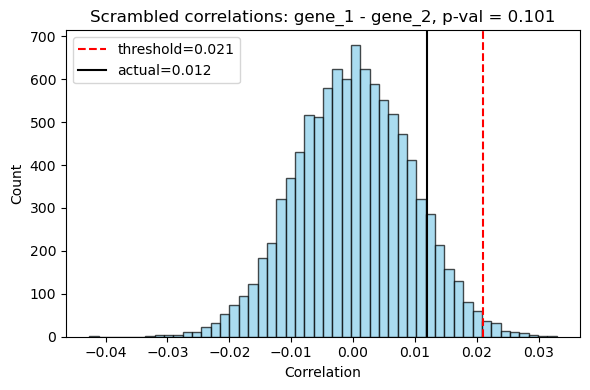

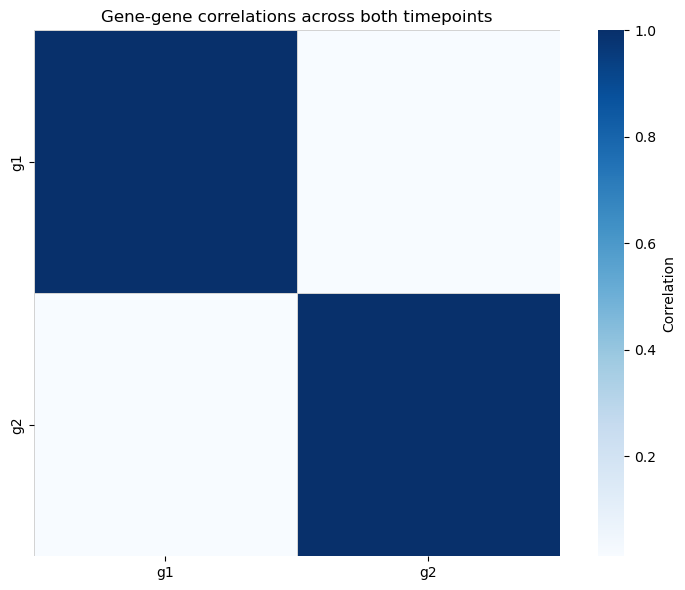

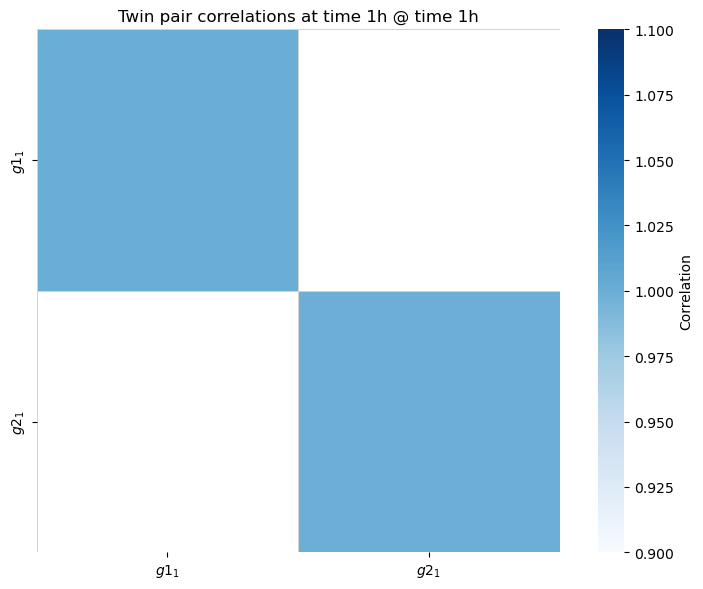

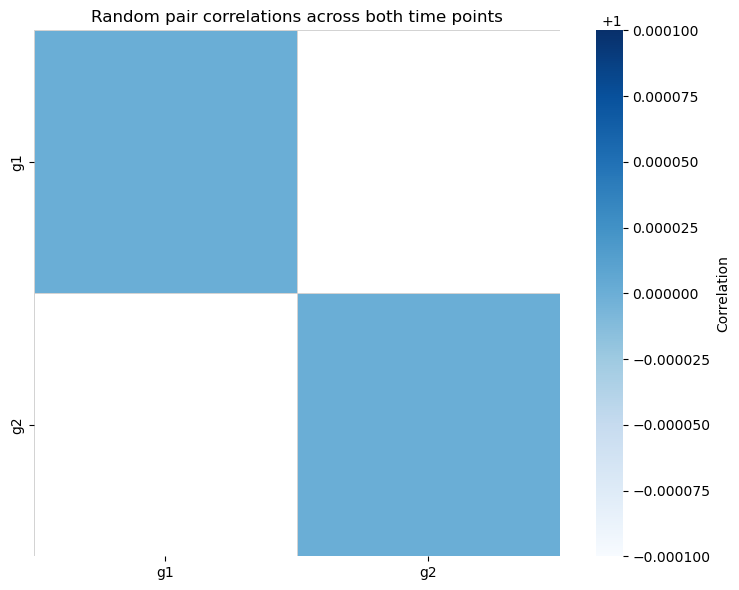


1. No Regulation
  gene_1 - gene_2
  gene_2 - gene_1

2. Single-State Regulation
  (none)

3. Multiple States (No Regulation)
  (none)

4. Multiple States with Regulation
  (none)
['gene_1', 'gene_2']
[('gene_1', 'gene_1')]


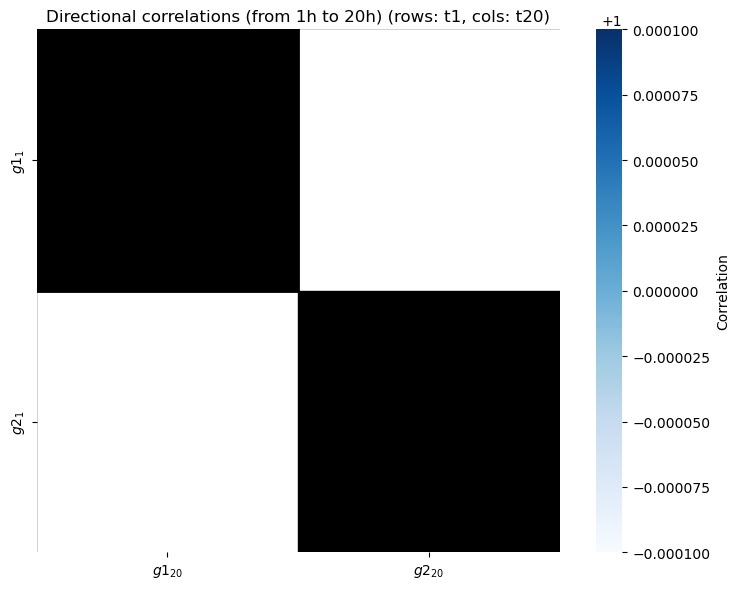

/projects/b1042/GoyalLab/Keerthana/grnInference/code/TwINFER/TwINFER_function_scripts/correlation_analysis_helpers.py:698: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


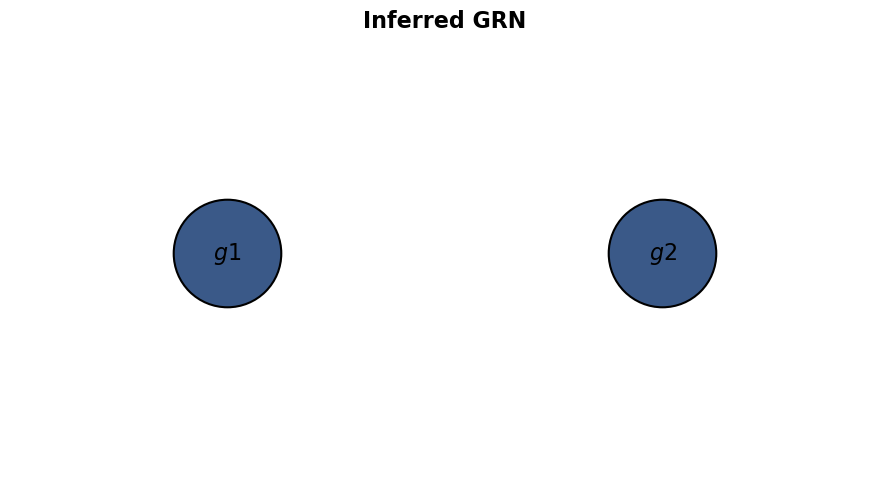

In [129]:
correlation_matrices = infer_with_twinfer(**twinfer_kwargs)